In [1]:
import torch
import numpy as np
from figures.load_data2 import load_data
import matplotlib.pyplot as plt
import mne
import pandas as pd
import json
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

def load_config(file_path='../experiments/params.json'):
    with open(file_path, 'r') as file:
        config = json.load(file)
    return config

K=5

In [2]:
modeltypes = ['group','mm','mmms','AA']
df = pd.read_csv('../data/SPCA_selectedregu_results/SPCA_results_selectedreguK='+str(K)+'.csv')
ordering = np.zeros((K,4),dtype=int)
for m,model in enumerate(modeltypes):
    df_model = df[df['modeltype']==model].reset_index(drop=True)
    idx = df_model['test_loss'].idxmin()
    C = np.load('../data/SPCA_selectedregu_results/SPCA_results_selectedregu_C_'+model+str(idx)+'K='+str(K)+'.npy')
    S = np.load('../data/SPCA_selectedregu_results/SPCA_results_selectedregu_S_'+model+str(idx)+'K='+str(K)+'.npy')

    if model == 'group':
        ref = S[0]
        C2 = C[:159]+C[159:159*2]+C[159*2:]
        maxidx = np.argmax(np.abs(C2),axis=0)
        ordering[:,0] = np.argsort(maxidx)
        ref = ref[ordering[:,0]]
    else:
        if model == 'mm':
            S_ref = np.mean(S,axis=0)
        elif model == 'mmms' or model=='AA':
            S_ref = np.mean(S,axis=(0,1))
        #reorder columns of C according to their correlation with the reference C
        corr = np.zeros((K,K))
        best_perm = np.zeros(K,dtype=int)
        for i in range(K):
            for j in range(K):
                corr[i,j] = np.abs(np.corrcoef(S_ref[j,:],ref[i,:])[0,1])
            best_perm[i] = np.nanargmax(corr[i,:])
            S_ref[best_perm[i],:] = 0
        ordering[:,m] = best_perm
ordering

array([[0, 0, 4, 1],
       [4, 4, 0, 2],
       [2, 1, 1, 3],
       [3, 3, 2, 4],
       [1, 2, 3, 0]])

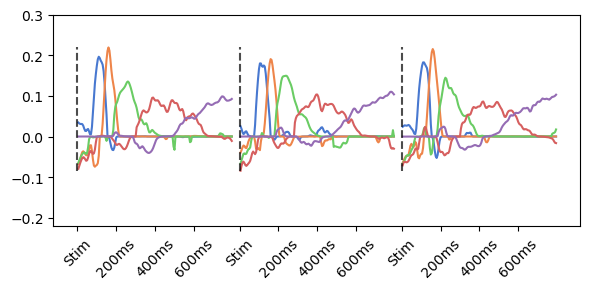

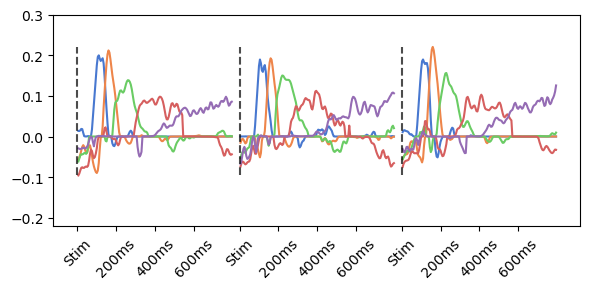

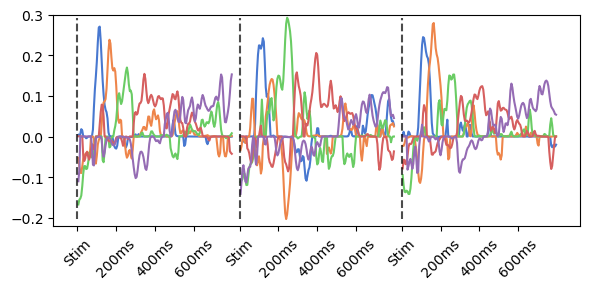

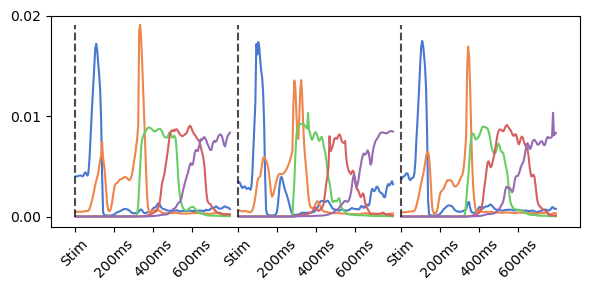

In [7]:
modeltypes = ['group','mm','mmms','AA']
palette = sns.color_palette("muted")
times = np.array(torch.load('../data/MEEGtimes.pt'))
t = np.max(times)+0.04
df = pd.read_csv('../data/SPCA_selectedregu_results/SPCA_results_selectedreguK='+str(K)+'.csv')
for m,model in enumerate(modeltypes):
    df_model = df[df['modeltype']==model].reset_index(drop=True)
    #find index of smallest test loss   
    idx = df_model['test_loss'].idxmin()
    #load C matrix
    C = np.load('../data/SPCA_selectedregu_results/SPCA_results_selectedregu_C_'+model+str(idx)+'K='+str(K)+'.npy')
    C = C[:,ordering[:,m]]
    if model != 'AA':
        for k in range(K):
            if np.sum(C[:159,k]+C[159:159*2,k]+C[159*2:,k])<0:
                C[:,k] = -C[:,k]

    fig,ax = plt.subplots(1,1,figsize=(6,3))
    for c in range(3):
        if c==0:
            idx = np.arange(0,159)
        elif c==1:
            idx = np.arange(159,159*2)
        else:
            idx = np.arange(159*2,159*3)
        for k in range(K):
            ax.plot(times[times>0]+t*c,C[idx,k],color=palette[k]) 
            ax.set_xticks([0,0.2,0.4,0.6,t,t+0.2,t+0.4,t+0.6,t*2,t*2+0.2,t*2+0.4,t*2+0.6]);
            # ax.set_xticklabels(['Stim','0.5s','Stim','0.5s','Stim','0.5s'],rotation=45);
            ax.set_xticklabels(['Stim','200ms','400ms','600ms','Stim','200ms','400ms','600ms','Stim','200ms','400ms','600ms'],rotation=45);
            if model=='AA':
                ax.set_yticks([-0.02,-0.01,0,0.01,0.02])
                ax.set_ylim([-0.001,0.02])
            else:
                ax.set_yticks([-0.2,-0.1,0,0.1,0.2,0.3])
                ax.set_ylim([-0.22,0.30])
        ax.vlines([t*c],ymin=np.min(np.array(C)),ymax=np.max(np.array(C)),linestyles='dashed',colors='k',alpha=0.7);

    plt.tight_layout()
    plt.savefig('../reports/C_'+model+'.png',dpi=300)

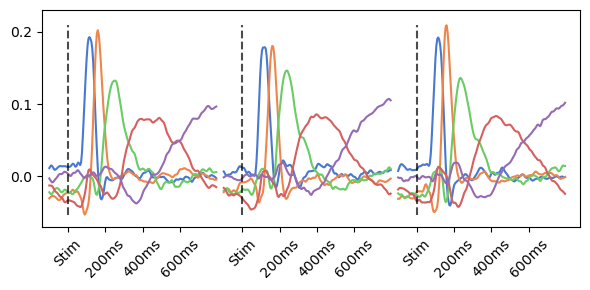

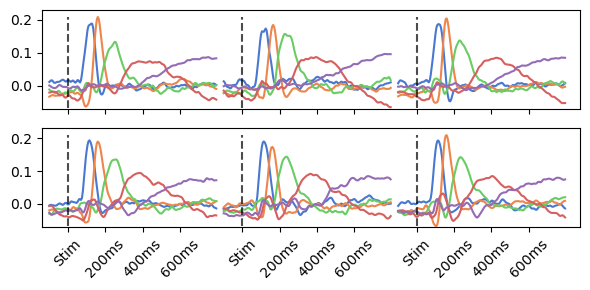

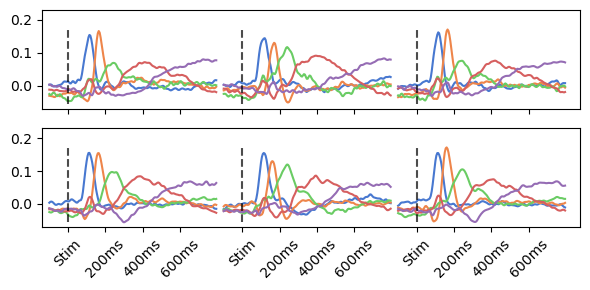

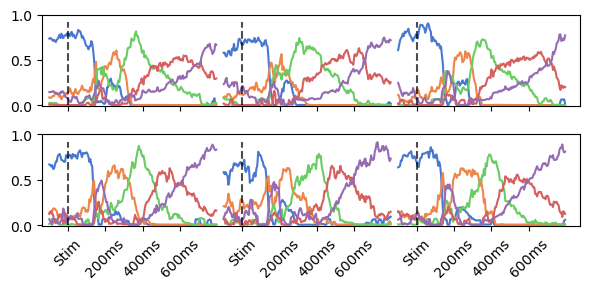

In [8]:
def ax_plot(ax,data,model):
    palette = sns.color_palette("muted")
    times = np.array(torch.load('../data/MEEGtimes.pt'))
    t = np.max(times)-np.min(times)+0.04
    for k in range(K):
        ax.plot(times+t*c,data[:,k],color=palette[k]) 
        ax.set_xticks([0,0.2,0.4,0.6,t,t+0.2,t+0.4,t+0.6,t*2,t*2+0.2,t*2+0.4,t*2+0.6]);
        # ax.set_xticklabels(['Stim','0.5s','Stim','0.5s','Stim','0.5s'],rotation=45);
        ax.set_xticklabels(['Stim','200ms','400ms','600ms','Stim','200ms','400ms','600ms','Stim','200ms','400ms','600ms'],rotation=45);
    ax.vlines([t*c],ymin=np.min(np.array(S)),ymax=np.max(np.array(S)),linestyles='dashed',colors='k',alpha=0.7);
    if model=='AA':
        ax.set_yticks([0,0.5,1])
        ax.set_ylim([-0.01,1])
    else:
        ax.set_yticks([-0.1,0,0.1,0.2])
        ax.set_ylim([-0.07,0.23])
    ax.set_xlim([np.min(times)-0.04,np.min(times)+t*3+0.04])
    return ax

modeltypes = ['group','mm','mmms','AA']
times = np.array(torch.load('../data/MEEGtimes.pt'))
df = pd.read_csv('../data/SPCA_selectedregu_results/SPCA_results_selectedreguK='+str(K)+'.csv')
for m,model in enumerate(modeltypes):
    df_model = df[df['modeltype']==model].reset_index(drop=True)
    #find index of smallest test loss   
    idx = df_model['test_loss'].idxmin()
    #load C matrix
    C = np.load('../data/SPCA_selectedregu_results/SPCA_results_selectedregu_C_'+model+str(idx)+'K='+str(K)+'.npy')
    C = C[:,ordering[:,m]]
    S = np.load('../data/SPCA_selectedregu_results/SPCA_results_selectedregu_S_'+model+str(idx)+'K='+str(K)+'.npy')
    
    if model=='mmms' or model=='AA':
        S = np.mean(S,axis=1)
    S = S[:,ordering[:,m],:]
    if model != 'AA':
        for k in range(K):
            if np.sum(C[:159,k]+C[159:159*2,k]+C[159*2:,k])<0:
                S[:,k] = -S[:,k]
    if model=='group':
        fig,axs = plt.subplots(1,1,figsize=(6,3))
    else:
        fig,axs = plt.subplots(2,1,figsize=(6,3))
    for c in range(3):
        if c==0:
            idx = np.arange(0,180)
        elif c==1:
            idx = np.arange(180,360)
        else:
            idx = np.arange(360,540)
        if model=='group':
            axs = ax_plot(axs,S[0,:,idx],model)
        else:
            axs[0] = ax_plot(axs[0],S[0,:,idx],model)
            axs[1] = ax_plot(axs[1],S[1,:,idx],model)
            axs[0].set_xticklabels('')
    plt.tight_layout()
    plt.savefig('../reports/S_'+model+'.png',dpi=300)

Reading /dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 70) active
    Found the data of interest:
        t =    -100.00 ...     795.00 ms (face/famous)
        0 CTF compensation matrices available
        nave = 148 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
Loading data...
Loading data...
Loading data...
Loading data...


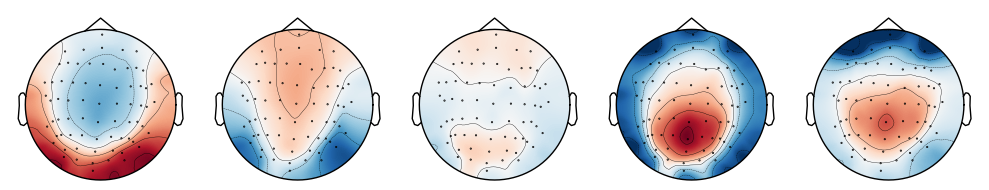

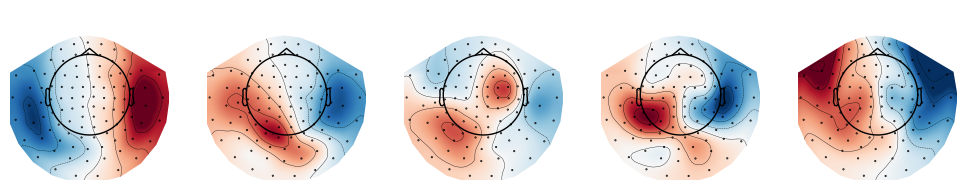

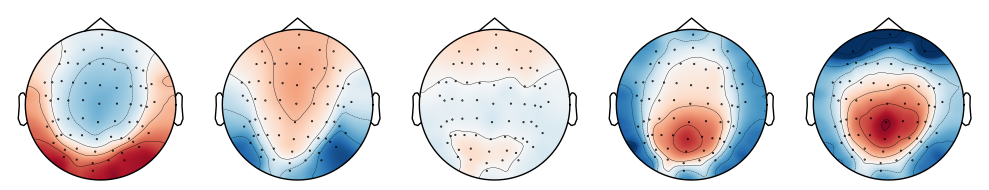

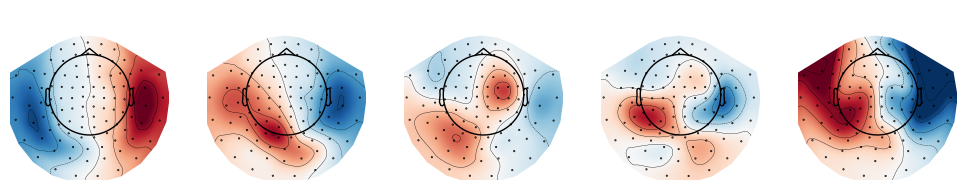

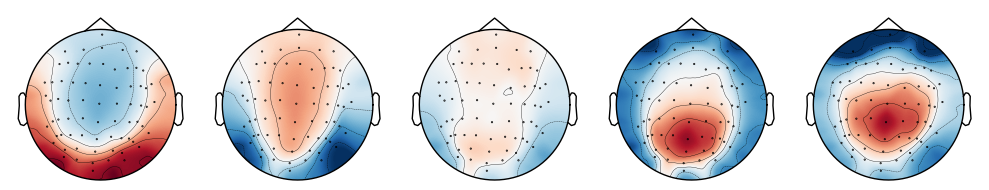

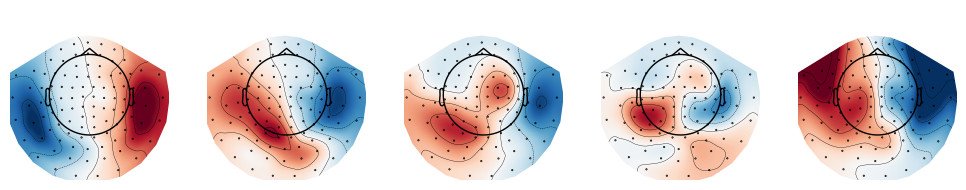

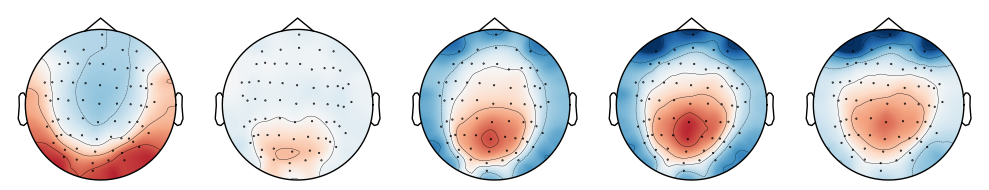

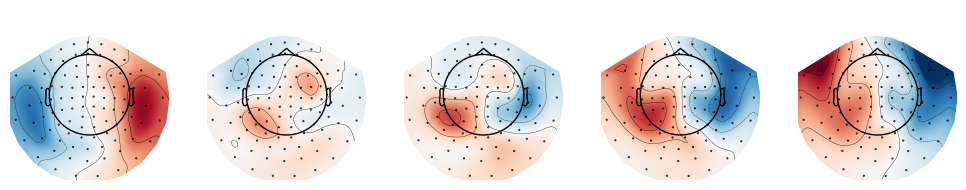

In [17]:
sub = '06'
evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]
a=evoked.get_channel_types()
times = np.array(torch.load('../data/MEEGtimes.pt'))
C_idx = np.tile(np.where(times>0)[0],3)
num_channels = [70,102]

modeltypes = ['group','mm','mmms','AA']
df = pd.read_csv('../data/SPCA_selectedregu_results/SPCA_results_selectedreguK='+str(K)+'.csv')
XCref_eeg = np.zeros((num_channels[0],K))
XCref_mag = np.zeros((num_channels[1],K))
for m,model in enumerate(modeltypes):
    df_model = df[df['modeltype']==model].reset_index(drop=True)
    #find index of smallest test loss   
    idx = df_model['test_loss'].idxmin()
    #load C matrix
    C = np.load('../data/SPCA_selectedregu_results/SPCA_results_selectedregu_C_'+model+str(idx)+'K='+str(K)+'.npy')
    C = C[:,ordering[:,m]]
    if model != 'AA':
        for k in range(K):
            if np.sum(C[:159,k]+C[159:159*2,k]+C[159*2:,k])<0:
                C[:,k] = -C[:,k]
    if model == 'AA':
        X_train,_ = load_data(data_pool='all',type='mmms',preproc='split',as_numpy_array=True) 
    elif model == 'group': 
        X_train,_ = load_data(data_pool='all',type='group',preproc='split',as_numpy_array=True)
        X_train['all2'] = X_train['all']
    else:
        X_train,_ = load_data(data_pool='all',type=model,preproc='split',as_numpy_array=True)  
    for m2,key in enumerate(X_train):
        fig,axs = plt.subplots(1,K,figsize=(10,2))
        for k in range(K):
            if model=='group':
                XC = X_train[key][:,C_idx]@C[:,k]
                if m2==0:
                    ch_type = 'eeg'
                    XC = np.mean(XC[:16*70].reshape(16,num_channels[m2]),axis=0)
                    evoked.data[np.where(np.array(a)==ch_type)] = np.tile(XC,(180,1)).T/1e6
                    XCref_eeg[:,k] = XC
                else:
                    ch_type = 'mag'
                    XC = np.mean(XC[16*70:].reshape(16,num_channels[m2]),axis=0)
                    evoked.data[np.where(np.array(a)==ch_type)] = np.tile(XC,(180,1)).T/1e15
                    XCref_mag[:,k] = XC
                  
            elif model=='mm':
                XC = np.mean((X_train[key][:,C_idx]@C[:,k]).reshape(16,num_channels[m2]),axis=0)
            else:
                XC = np.mean((X_train[key][:,:,C_idx]@C[:,k]),axis=0)
            if key=='EEG':
                # if np.corrcoef(XC,XCref_eeg[:,k])[0,1]<0:
                #     XC = -XC
                ch_type = 'eeg'
                evoked.data[np.where(np.array(a)==ch_type)] = np.tile(XC,(180,1)).T/1e6
            elif key=='MEG':
                # if np.corrcoef(XC,XCref_mag[:,k])[0,1]<0:
                #     XC = -XC
                ch_type = 'mag'
                evoked.data[np.where(np.array(a)==ch_type)] = np.tile(XC,(180,1)).T/1e15
            
            if model=='AA':
                if ch_type=='eeg':
                    vlim = [-0.02,0.02]
                elif ch_type=='mag':
                    vlim = [-0.01,0.01]
            else:
                if ch_type=='eeg':
                    vlim = [-0.2,0.2]
                elif ch_type=='mag':
                    vlim = [-0.1,0.1]


            # if k==4:
            #     mne.viz.topomap.plot_evoked_topomap(evoked,times=[0.1],ch_type=ch_type,show_names=False,colorbar=True,show=False,extrapolate='auto',sphere=(0.0, 0.0, 0.0, 0.09),axes=(axs[k],axs[k+1]));
            # else:
            mne.viz.topomap.plot_evoked_topomap(evoked,
                                                times=[0.1],
                                                ch_type=ch_type,
                                                show_names=False,
                                                colorbar=False,
                                                show=False,
                                                extrapolate='auto',
                                                sphere=(0.0, 0.0, 0.0, 0.09),
                                                vlim=vlim,
                                                axes=axs[k]);
            axs[k].set_title('')
        plt.tight_layout();
        plt.savefig('../reports/Topo_'+model+'_'+key+'.png',dpi=300)